In [1]:
import pandas as pd
import numpy as np 
import scanpy as sc

In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [12]:
adata = sc.read_h5ad('scRNAseq_pancan_normalized_after_scanvi.h5ad')
Ychrgenes = ['DDX3Y', 'UTY', 'KDM5D', 'USP9Y', 'ZFY', 'RPS4Y1', 'TMSB4Y', 'EIF1AY', 'NLGN4Y']

# Model Running

In [4]:
import joblib

In [5]:
rf_classifier_loaded = joblib.load('9YgenesonlyFinalnew_model.pkl')
rf_classifier_loaded

RandomForestClassifier(random_state=42)

In [8]:
#Check Ychr gene existence
set(Ychrgenes).difference(adata.var_names)

set()

In [9]:
#Obtain expression matrix
X_tumor = adata[:, Ychrgenes].X.todense()
X_tumor = pd.DataFrame(X_tumor, columns=Ychrgenes, index=adata.obs.index)

In [10]:
# Use the trained model to predict LOY status on tumor data
tumor_predictions = rf_classifier_loaded.predict(X_tumor)

In [14]:
# Get results and Renaming
adata.obs["RL_Prediction_Only9genes"]=tumor_predictions.copy()
adata.obs['LOY'] = adata.obs["RL_Prediction_Only9genes"].map({0: 'WTY_SCR', 1: 'LOY_SCR'})
adata.obs['LOY'].value_counts()
# Save
adata.write_h5ad('scRNAseq_pancan_normalized_after_scanvi.h5ad')

# Model check

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored

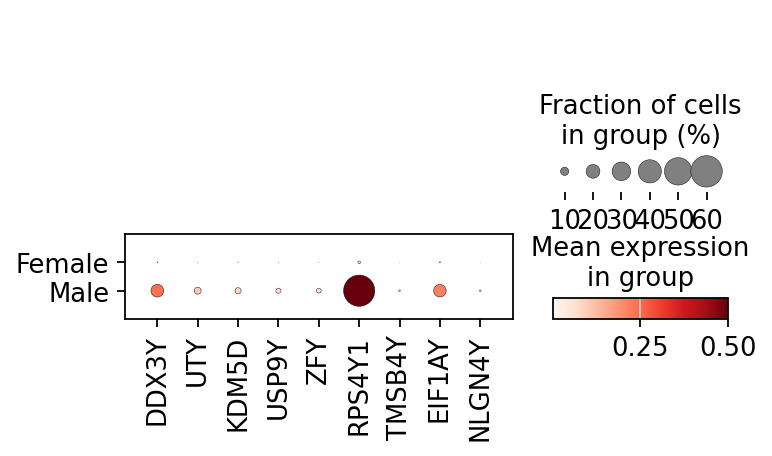

In [100]:
#Extended Data Fig4b
sc.pl.dotplot(adata, Ychrgenes, use_raw=False,groupby='Sex',vmax=0.5,
              save='Extend_Fig4b_9Ychr_genes_expr_FemalevsMale_All.pdf')

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


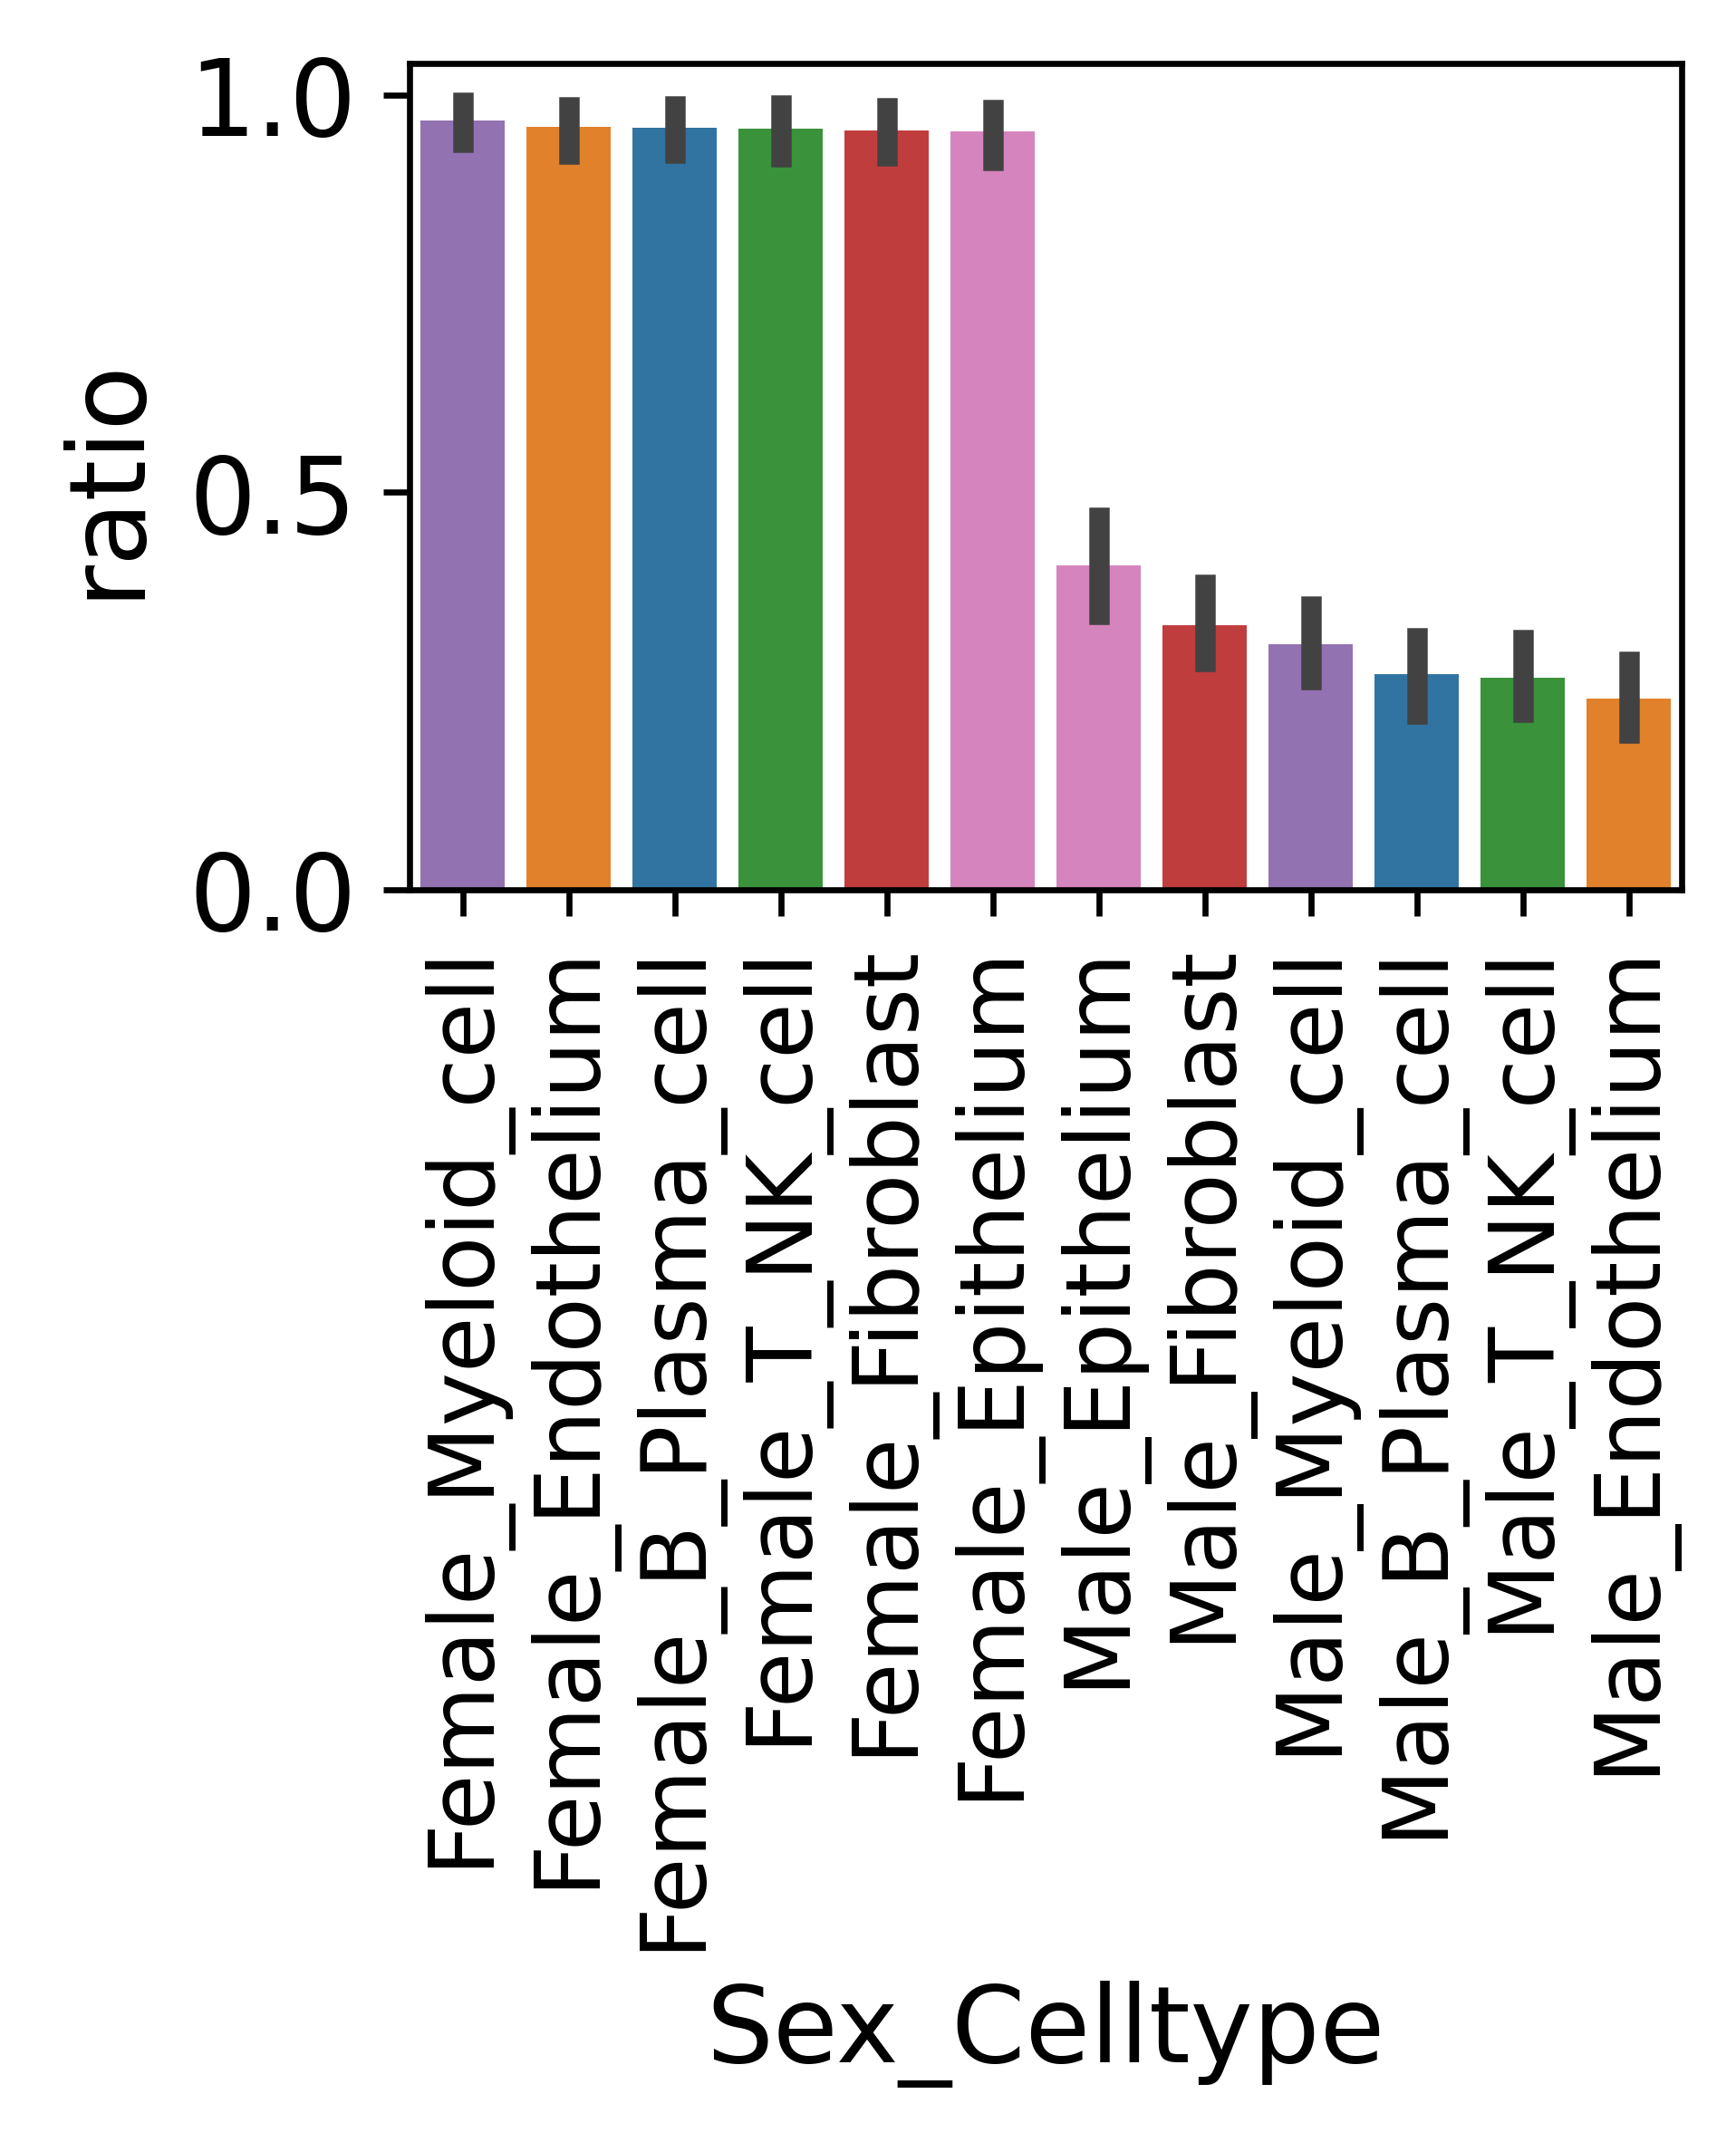

In [102]:
# Extended Data Fig4c
#Set group
adata.obs['Sex_Celltype'] = adata.obs['Sex'].astype('str')+'_'+adata.obs['Celltype1'].astype('str')
# Count number of cells in each group
counts = adata.obs.groupby(['DataSampleID', 'Sex_Celltype', 'LOY']).size().reset_index(name='count')
# Pivot table to reshape data and then calculate ratio
pivot_tabletissue = counts.pivot_table(index=['DataSampleID', 'Sex_Celltype'],
                                       columns='LOY', values='count', fill_value=0)
pivot_tabletissue['ratio'] = pivot_tabletissue['LOY_SCR'] / (pivot_tabletissue['LOY_SCR'] + pivot_tabletissue['WTY_SCR'])
pivot_tabletissue = pivot_tabletissue.reset_index(level='Sex_Celltype')

# Sort the mean LOY ratio for each cell type in each sex
sorted_order = pivot_tabletissue.groupby('Sex_Celltype')['ratio'].mean().sort_values(ascending=False).index
#Set colors
color_palette = {
    'Male_B_Plasma_cell':'#1F77B4',
    'Male_Endothelium':'#FF7F0E',
    'Male_Epithelium': '#E377C2',
    'Male_Fibroblast':'#D62728',
    'Male_Myeloid_cell':'#9467BD',
    'Male_T_NK_cell':'#2CA02C',
    
    'Female_B_Plasma_cell':'#1F77B4',
    'Female_Endothelium':'#FF7F0E',
    'Female_Epithelium': '#E377C2',
    'Female_Fibroblast':'#D62728',
    'Female_Myeloid_cell':'#9467BD',
    'Female_T_NK_cell':'#2CA02C',
}
#Plotting
fig, ax = plt.subplots(figsize=(3,2), dpi= 300)
sns.barplot(data=pivot_tabletissue, x='Sex_Celltype', palette=color_palette, y='ratio',order=sorted_order)
plt.xticks(rotation=90, fontsize=12)
ax.grid(False)
plt.savefig('Extend_Fig4c_LOYratio_Sex_Celltype.pdf', dpi=300, bbox_inches='tight')

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored

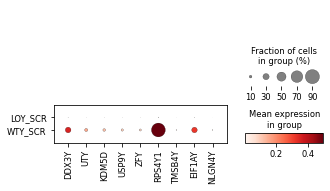

In [13]:
#Extended Data Fig4d
sc.pl.dotplot(adata[adata.obs['Sex']=='Male',:], Ychrgenes, use_raw=False,groupby='LOY',vmax=0.5,
              save='Extend_Fig4d_9Ychr_genes_expr_WTYvsLOY_male.pdf')

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


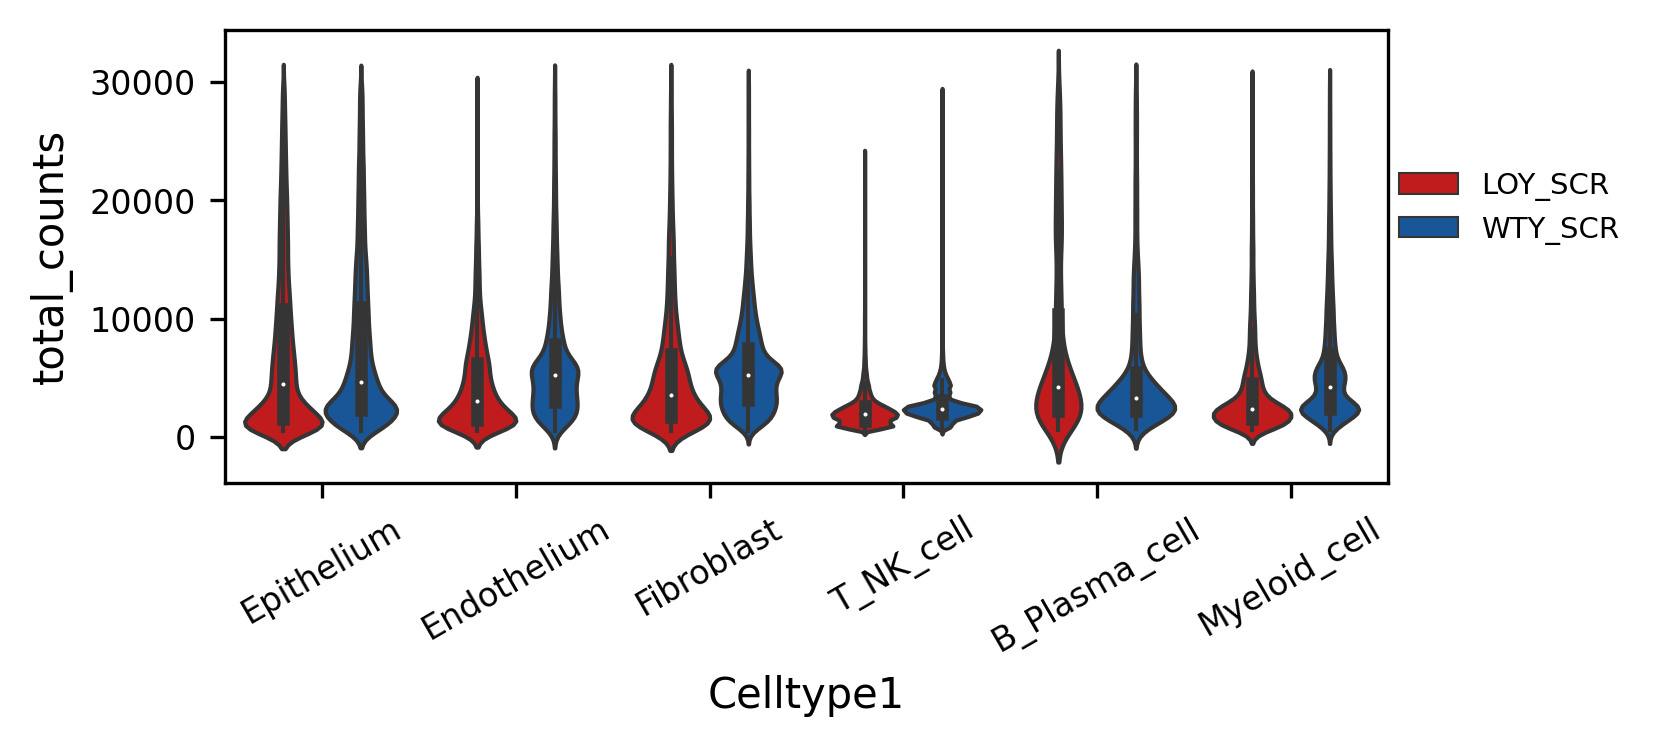

In [14]:
#Extended Data Fig4e
fig, ax = plt.subplots(figsize=(5,2), dpi= 300)
color_palette = {
    'LOY_SCR':'#c11c1d',
    'WTY_SCR':'#195697'
}
sns.violinplot(adata.obs.loc[adata.obs['Sex']=='Male',:], x='Celltype1',y='total_counts',hue='LOY',linewidth=1,
               palette=color_palette,hur_order = ['WTY_SCR','LOY_SCR'],
               saturation=1,linecolor="black")
plt.legend(loc = (1,0.5), fontsize = 7, frameon=False)
plt.xticks(rotation=30, fontsize=8)
plt.yticks(fontsize=8)
ax.grid(False)
plt.savefig('Extend_Fig4e_violinplot_Totalcounts_LOY.pdf', dpi=300, bbox_inches='tight')

In [6]:
#Calculate chromosome scores
gene_df = pd.read_csv('scRNAseq_gene_chr_info.csv',index_col=0)
chrom = gene_df['chromosome'].unique()
for c in chrom:
    marker_Genes = gene_df.index[gene_df['chromosome']==c].tolist()
    sc.tl.score_genes(
        adata,
        marker_Genes,
        ctrl_size=50,
        gene_pool=None,
        n_bins=25,
        score_name='chr_'+c+'_score',
        random_state=0,
        copy=False,
        use_raw=False
    )
adata.obs.loc[:,chr_scores].to_csv('Pancancer_scRNAseq_chr_scores.csv')

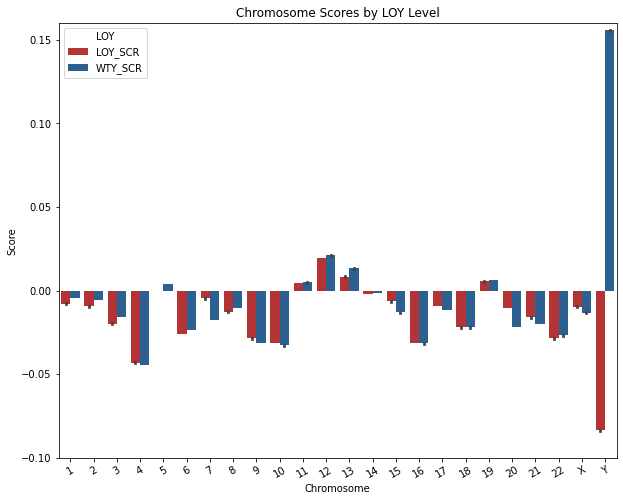

In [24]:
#Extended Data Fig3h
data = pd.read_csv('Pancancer_scRNAseq_chr_scores.csv',index_col=0)

chr_scores = ['chr_1_score','chr_2_score','chr_3_score','chr_4_score','chr_5_score',
              'chr_6_score','chr_7_score','chr_8_score','chr_9_score',
              'chr_10_score','chr_11_score','chr_12_score','chr_13_score','chr_14_score',
              'chr_15_score','chr_16_score','chr_17_score','chr_18_score','chr_19_score',
              'chr_20_score','chr_21_score','chr_22_score','chr_X_score','chr_Y_score']
data = data.loc[:,chr_scores].copy()
data['Sex'] = adata.obs['Sex'].copy()
data['LOY'] = adata.obs['LOY'].copy()
melted_data = data.loc[data['Sex']=='Male',:].melt(id_vars='LOY', value_vars=chr_scores, var_name='Chromosome', 
                             value_name='Score')
melted_data['Chromosome'] = [chrom[4:-6] for chrom in melted_data['Chromosome']]

custom_palette = {'LOY_SCR': '#c91f20', 'WTY_SCR': '#1b61a1'}
plt.figure(figsize=(10, 8))
ax = sns.barplot(data=melted_data,
            x='Chromosome', y='Score', hue='LOY', palette=custom_palette)
ax.set_facecolor=('white')
ax.set(ylim=(-0.1,0.16))
y_majorocator=MultipleLocator(0.05)
ax.yaxis.set_major_locator(y_majorocator)
plt.xticks(rotation=30)
plt.title('Chromosome Scores by LOY Level')
plt.xlabel('Chromosome')
plt.ylabel('Score')

plt.savefig('Extend_Fig4f_bar_Chr_scores.pdf', dpi=300, bbox_inches='tight')